In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import igraph as ig
import numpy as np
from collections import Counter
import pickle

In [5]:
with open("G_bot.pkl", "rb") as f:
    G_bot = pickle.load(f)
with open("G_ide.pkl", "rb") as f:
    G_ide = pickle.load(f)

In [8]:
def plot_network(G, title="Network", node_color=None):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_color, cmap="tab20")
    nx.draw_networkx_edges(G, pos, alpha=0.25)
    plt.title(title)
    plt.axis("off")
    plt.show()


def to_igraph(G):
    """networkx graph → igraph graph"""
    mapping = {node: idx for idx, node in enumerate(G.nodes())}
    edges = [(mapping[u], mapping[v]) for u, v in G.edges()]
    g = ig.Graph(edges=edges, directed=False)
    g.vs["name"] = list(mapping.keys())
    return g

## 1. Visualisation

/opt/anaconda3/envs/msd_course/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:1438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


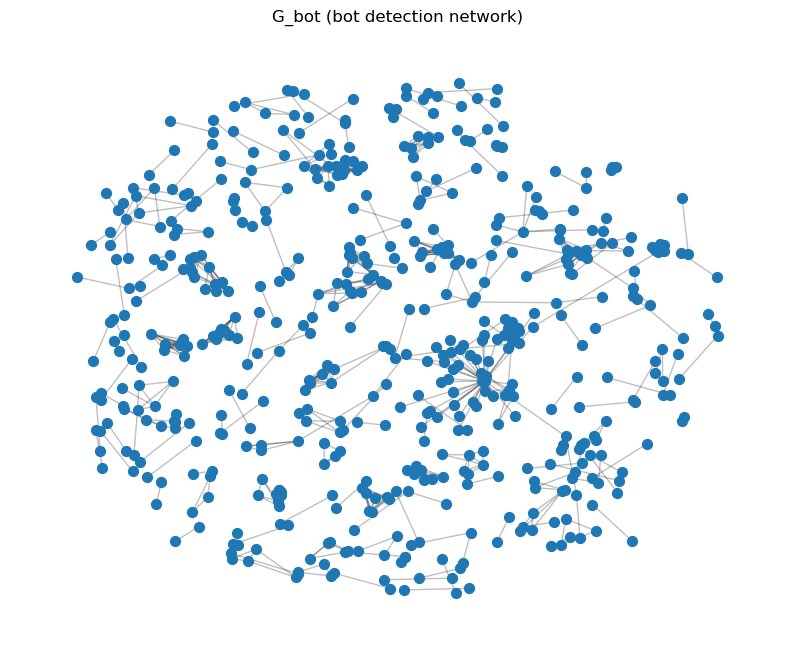

KeyboardInterrupt: 

<Figure size 1000x800 with 0 Axes>

In [9]:
plot_network(G_bot, "G_bot (bot detection network)")
plot_network(G_ide, "G_ide (ideology/topic network)")

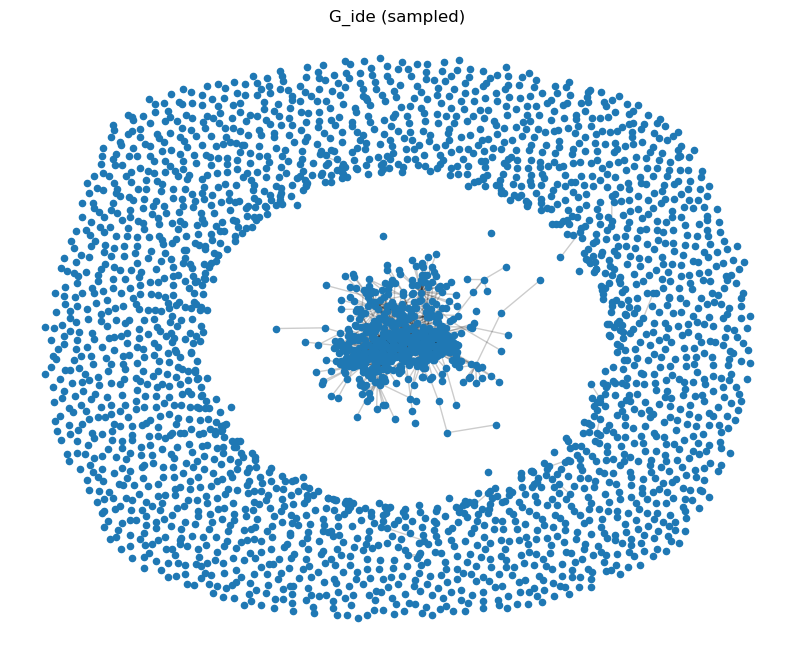

In [13]:
import random
def plot_sample(G, sample_size=3000, title="Sampled Graph"):
    if G.number_of_nodes() <= sample_size:
        H = G
    else:
        sampled_nodes = random.sample(list(G.nodes()), sample_size)
        H = G.subgraph(sampled_nodes).copy()

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(H, seed=42)
    nx.draw_networkx_nodes(H, pos, node_size=20)
    nx.draw_networkx_edges(H, pos, alpha=0.2)
    plt.title(title)
    plt.axis("off")
    plt.show()

# 对你的 G_ide 巨型网络：
plot_sample(G_ide, sample_size=3000, title="G_ide (sampled)")

## 2. Compute connected components

In [10]:
def print_components(G, name="Graph"):
    comps = list(nx.connected_components(G))
    comps_sizes = [len(c) for c in comps]
    print(f"\n===== {name}: Connected Components =====")
    print(f"Number of components: {len(comps)}")
    print(f"Size distribution: {Counter(comps_sizes)}")

print_components(G_bot, "G_bot")
print_components(G_ide, "G_ide")


===== G_bot: Connected Components =====
Number of components: 163
Size distribution: Counter({2: 102, 3: 26, 6: 8, 4: 7, 5: 5, 9: 4, 7: 4, 10: 2, 8: 1, 51: 1, 13: 1, 12: 1, 16: 1})

===== G_ide: Connected Components =====
Number of components: 45
Size distribution: Counter({2: 32, 3: 7, 4: 2, 190352: 1, 17: 1, 5: 1, 9: 1})


## 3. Select giant component

In [11]:
def get_giant_component(G):
    giant = max(nx.connected_components(G), key=len)
    return G.subgraph(giant).copy()

G_bot_gc = get_giant_component(G_bot)
G_ide_gc = get_giant_component(G_ide)

print(f"G_bot giant component size: {G_bot_gc.number_of_nodes()}")
print(f"G_ide giant component size: {G_ide_gc.number_of_nodes()}")

G_bot giant component size: 51
G_ide giant component size: 190352


## 4. Use Louvain method to detect communities

In [16]:
def detect_communities(G, name="Graph"):
    g_ig = to_igraph(G)
    communities = g_ig.community_multilevel()  # Louvain
    membership = communities.membership

    print(f"\n===== {name}: Louvain Communities =====")
    print(f"Number of communities: {len(communities)}")
    sizes = Counter(membership)
    print(f"Community size distribution: {sizes}")

    # 可视化 - 节点按社区着色
    # node_colors = membership
    # plot_network(G, f"{name}: Communities (Louvain)", node_color=node_colors)

    return membership, communities


bot_membership, bot_comms = detect_communities(G_bot_gc, "G_bot GC")
ide_membership, ide_comms = detect_communities(G_ide_gc, "G_ide GC")


===== G_bot GC: Louvain Communities =====
Number of communities: 2
Community size distribution: Counter({0: 36, 1: 15})

===== G_ide GC: Louvain Communities =====
Number of communities: 17
Community size distribution: Counter({1: 66933, 7: 22597, 2: 20123, 3: 17212, 11: 10189, 4: 10038, 5: 8634, 0: 7069, 6: 6764, 9: 5592, 10: 5559, 8: 4397, 13: 2941, 14: 1252, 12: 1029, 16: 14, 15: 9})


In [17]:
bot_membership_all, bot_comms_all = detect_communities(G_bot, "G_bot")


===== G_bot: Louvain Communities =====
Number of communities: 164
Community size distribution: Counter({35: 36, 143: 16, 72: 15, 75: 13, 100: 12, 3: 10, 13: 10, 6: 9, 31: 9, 80: 9, 158: 9, 14: 8, 7: 7, 34: 7, 99: 7, 109: 7, 5: 6, 23: 6, 52: 6, 64: 6, 90: 6, 133: 6, 136: 6, 162: 6, 11: 5, 19: 5, 22: 5, 74: 5, 106: 5, 1: 4, 48: 4, 82: 4, 84: 4, 117: 4, 130: 4, 135: 4, 4: 3, 8: 3, 9: 3, 10: 3, 12: 3, 17: 3, 29: 3, 40: 3, 47: 3, 51: 3, 53: 3, 55: 3, 60: 3, 67: 3, 70: 3, 73: 3, 76: 3, 89: 3, 91: 3, 107: 3, 108: 3, 110: 3, 116: 3, 119: 3, 131: 3, 160: 3, 0: 2, 2: 2, 15: 2, 16: 2, 18: 2, 20: 2, 21: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 30: 2, 32: 2, 33: 2, 36: 2, 37: 2, 38: 2, 39: 2, 41: 2, 42: 2, 43: 2, 44: 2, 45: 2, 46: 2, 49: 2, 50: 2, 54: 2, 56: 2, 57: 2, 58: 2, 59: 2, 61: 2, 62: 2, 63: 2, 65: 2, 66: 2, 68: 2, 69: 2, 71: 2, 77: 2, 78: 2, 79: 2, 81: 2, 83: 2, 85: 2, 86: 2, 87: 2, 88: 2, 92: 2, 93: 2, 94: 2, 95: 2, 96: 2, 97: 2, 98: 2, 101: 2, 102: 2, 103: 2, 104: 2, 105: 2, 111: 2, 112: 2

## Save info for task 3

In [43]:
# giant component of ide network
with open("G_ide_gc.pkl", "wb") as f:
    pickle.dump(G_ide_gc, f)

In [48]:
# communities of giant component of bot network
with open("G_bot_gc_comms.pkl", "wb") as f:
    pickle.dump(bot_comms, f)
# communities of complete bot network
with open("G_bot_full_comms.pkl", "wb") as f:
    pickle.dump(bot_comms_all, f)
# communities of giant component of ide network
with open("G_ide_gc_comms.pkl", "wb") as f:
    pickle.dump(ide_comms, f)

## Examples for Task 3

In [50]:
with open("G_ide_gc_comms.pkl", "rb") as f:
    communities = pickle.load(f)

In [51]:
k = 5   # 选择第 0 个社区，你可以改成其他编号

# 社区中的节点索引
community_nodes = communities[k]  

# 将 igraph 节点索引转为原始账户 ID
community_users = [node for node in community_nodes]

print("Selected community:", k)
print("Number of users:", len(community_users))
print("User list example:", community_users[:20])


Selected community: 5
Number of users: 8634
User list example: [17, 37, 38, 85, 252, 288, 335, 338, 349, 350, 412, 416, 424, 484, 501, 515, 536, 566, 613, 652]
